# Detroit blight data challenge

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions**

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
    state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [ ]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
#from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_auc_score, roc_curve

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preparation

In [ ]:
!unzip /content/Detroit_tables.zip

Archive:  /content/Detroit_tables.zip
replace latlons.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace addresses.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
df_train = pd.read_csv('train.csv', encoding = "ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding = "ISO-8859-1")

# delete NaN in target values
df_train.dropna(subset=['compliance'], inplace = True)

# delete one unnecessary row
df_train.drop(df_train[df_train.agency_name == 'Neighborhood City Halls'].index, inplace=True)

# to_datetime
for col in ['ticket_issued_date', 'hearing_date']:
    df_train[col] = pd.to_datetime(df_train[col])
    df_test[col] = pd.to_datetime(df_test[col])

df_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
5,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,CA,908041512,NaN,USA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
6,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,MI,48038,NaN,USA,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
7,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,MI,48211,NaN,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [ ]:
# merge the addresses and lat/lons into the train and test DataFrames

df_addresses = pd.read_csv('addresses.csv', encoding = "ISO-8859-1")
df_latlons = pd.read_csv('latlons.csv', encoding = "ISO-8859-1")

df_coord = pd.merge(df_addresses, df_latlons, how='inner', left_on='address', right_on='address')

df_train = pd.merge(df_train, df_coord, how='inner', left_on='ticket_id', right_on='ticket_id')
df_test = pd.merge(df_test,  df_coord, how='inner', left_on='ticket_id', right_on='ticket_id')

In [ ]:
# feature selection
save_cols = ['disposition',
             'fine_amount',
             'discount_amount',
             'lat', 'lon',]

X = df_train[save_cols].copy()
y = df_train['compliance'].copy()
X_test = df_test[save_cols].copy()

# add column 'train'
X['train'] = 1
X_test['train'] = 0

# combine trainset и testset
combined = pd.concat([X, X_test])

# make OHE for trainset+testset
combined = pd.get_dummies(combined, columns=['disposition'], dummy_na=False)

# seperate trainset и testset
X = combined[combined['train'] == 1].copy()
X_test = combined[combined['train'] == 0].copy()

# delete column 'train'
del_cols = ['disposition_Responsible (Fine Waived) by Admis',
           'disposition_Responsible - Compl/Adj by Default',
           'disposition_Responsible - Compl/Adj by Determi',
           'disposition_Responsible by Dismissal']
X.drop(del_cols+['train'], axis=1, inplace=True)
X_test.drop(del_cols+['train'], axis=1, inplace=True)

# get time delta between from ticket_issued_date to hearing_date
X['time_delta'] = (df_train['hearing_date'] - df_train['ticket_issued_date'])/np.timedelta64(3600,'s')
X_test['time_delta'] = (df_test['hearing_date'] - df_test['ticket_issued_date'])/np.timedelta64(3600,'s')

# discount_rate
# X['discount_rate'] = (df_train['discount_amount'] / df_train['fine_amount']).fillna(1.0)
# X_test['discount_rate'] = (df_test['discount_amount'] / df_test['fine_amount']).fillna(1.0)

# fill NaNs for some of the cols
for col in ['lat', 'lon', 'time_delta']:
    mean = X[col].mean(axis=0)
    X[col].fillna(mean, inplace=True)
    X_test[col].fillna(mean, inplace=True)

print(X.shape, y.shape, X_test.shape)

(159879, 9) (159879,) (61001, 9)


In [ ]:
# short columns' names
new_cols = ['fine_amount', 'discount_amount',
            'lat', 'lon',
            'disposition_by Deter',
            'disposition_by Admission',
            'disposition_by Default',
            'disposition_by Determination',
            'time_delta']
            
X.columns = new_cols
X_test.columns = new_cols

# Data check

In [ ]:
def show_unique(data, what_cols):
    unique_dict = {'column':[], 'n_unique':[], 'type':[], 'NaNs, %':[]}
    for col in what_cols:
        unique_dict['column'].append(col)
        unique_dict['n_unique'].append(data[col].nunique())
        unique_dict['type'].append(data[col].dtypes)
        unique_dict['NaNs, %'].append(data[col].isna().sum() / len(data) * 100)    
    return pd.DataFrame(unique_dict)

show_unique(X, X.columns)
#show_unique(df_train, df_train.columns)

,column,n_unique,type,"NaNs, %"
0,fine_amount,40,float64,0.0
1,discount_amount,13,float64,0.0
2,lat,61560,float64,0.0
3,lon,66840,float64,0.0
4,disposition_by Deter,2,uint8,0.0
5,disposition_by Admission,2,uint8,0.0
6,disposition_by Default,2,uint8,0.0
7,disposition_by Determination,2,uint8,0.0
8,time_delta,27438,float64,0.0


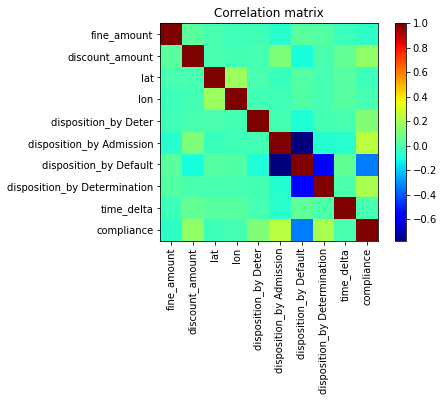

In [ ]:
def show_corr_matrix(df):
    df = df.corr()
    plt.imshow(df, cmap='jet') 
    plt.title('Correlation matrix')
    plt.yticks(ticks = np.arange(0,len(df.columns),1), labels = df.columns)
    plt.xticks(rotation=90)
    plt.xticks(ticks = np.arange(0,len(df.columns),1), labels = df.columns)
    plt.colorbar()
    plt.show();

show_corr_matrix(pd.concat([X, y], axis=1))    

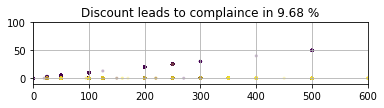

In [ ]:
plt.scatter(X['fine_amount'], X['discount_amount'], c=1-y, marker='o', s=5, alpha=0.2)
plt.title('Discount leads to complaince in {:.3} %'.
          format(100*len(X[(X['discount_amount']>1) & (y==1)]) / len(X[y==1])))
plt.ylim([-10,100])
plt.xlim([0,600])
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

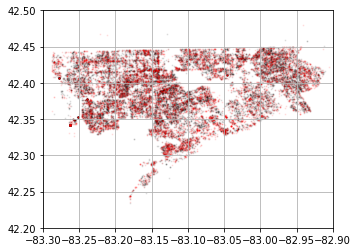

In [ ]:
plt.scatter(X['lon'][y==0][::10], X['lat'][y==0][::10], c='black', marker='o', s=1, alpha=0.08, label='0')
plt.scatter(X['lon'][y==1], X['lat'][y==1], c='red', marker='o', s=1, alpha=0.08, label='1')
plt.xlim([-83.3,-82.9])
plt.ylim([42.2,42.5])
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show();

# Model training

In [ ]:
# delete lat / lon - they are not helpfull even with KernelDensity
drop_cols = ['lat', 'lon']
X.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

## Lasso Regression

In [ ]:
# grid search cross-validation to optimize the model

clf = Lasso()
pipe = Pipeline([('scaler',  StandardScaler()), ('clf', clf)])

grid_values = {'clf__alpha': np.logspace(-3,-1, 15)}
grid = GridSearchCV(pipe, param_grid=grid_values, cv=3, scoring ='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X, y)

print('best_params: ', grid.best_params_)
print('best_score:  ', grid.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best_params:  {'clf__alpha': 0.0071968567300115215}
best_score:   0.7638775385699299


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.5s finished


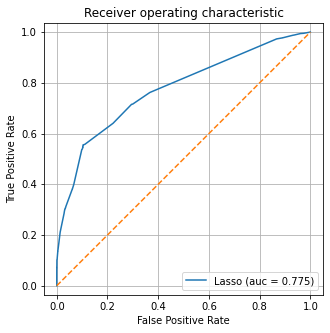

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_proba = best_model.predict(X_val)
y_proba = np.clip(y_proba, a_min=0, a_max=1)
fpr, tpr, thrs = roc_curve(y_val, y_proba)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='Lasso (auc = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.axis('equal')
plt.legend(loc="lower right")
plt.show();

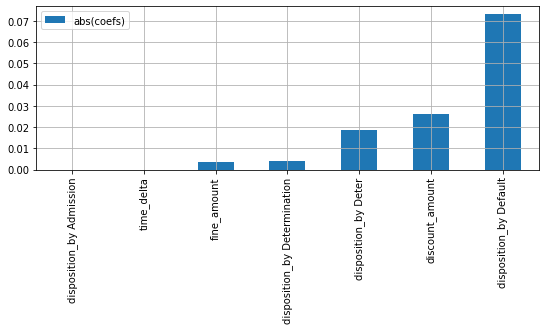

In [ ]:
# Feature importance
best_model = grid.best_estimator_
best_model.fit(X, y)

imp = pd.DataFrame(np.abs(best_model.steps[1][1].coef_),
                   index=X.columns, columns=['abs(coefs)'])
imp.sort_values('abs(coefs)').plot(kind='bar', figsize=(9, 3))
plt.grid()

## Random Forest

In [ ]:
# grid search cross-validation to optimize the model

clf = RandomForestClassifier(random_state = 0)
pipe = Pipeline([('scaler',  StandardScaler()), ('clf', clf)])

grid_values = {'clf__max_depth': range(3,6,1)}
grid = GridSearchCV(pipe, param_grid=grid_values, cv=3, scoring ='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X, y)

print('best_params: ', grid.best_params_)
print('best_score:  ', grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   24.4s finished


best_params:  {'clf__max_depth': 4}
best_score:   0.7738840393329336


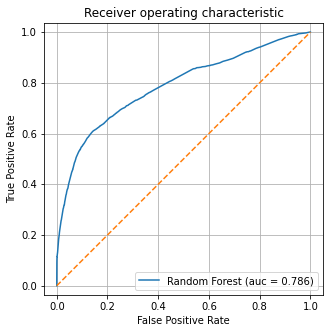

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_proba = best_model.predict_proba(X_val)
fpr, tpr, thrs = roc_curve(y_val, y_proba[:,1])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='Random Forest (auc = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.axis('equal')
plt.legend(loc="lower right")
plt.show();

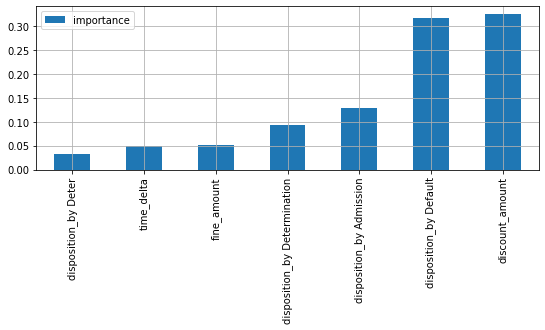

In [ ]:
# Feature importance
best_model = grid.best_estimator_
best_model.fit(X, y)

imp = pd.DataFrame(best_model.steps[1][1].feature_importances_,
                   index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='bar', figsize=(9, 3))
plt.grid()

# Submit

In [ ]:
best_model.fit(X, y)
y_test_proba = best_model.predict_proba(X_test)

submit = pd.Series(y_test_proba[:,1], index=df_test['ticket_id'])
submit.name = 'compliance'
submit

ticket_id
284932    0.055191
285362    0.036808
285361    0.054765
285338    0.054272
285346    0.054082
            ...   
376496    0.036985
376497    0.036985
376499    0.055239
376500    0.055239
369851    0.054567
Name: compliance, Length: 61001, dtype: float64